![alt text](../img/general/header.png)


# Compresión de modelos basados en ML



### Librerías

In [2]:
import os
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

## Tensorflow + Keras libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD, Adam
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning

## Quantization
from qkeras import *

## Datasets
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import fashion_mnist

from distillationClassKeras import *
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

/tools/anaconda3/envs/neuralEnv/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/tools/anaconda3/envs/neuralEnv/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2025-04-14 19:42:56.128067: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


### Habilitación de GPU 

In [3]:
# GPU
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

import tensorflow as tf
print("GPUs: ", len(tf.config.experimental.list_physical_devices('GPU')))

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

GPUs:  1


2025-04-14 19:42:57.831633: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2025-04-14 19:42:58.289821: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-04-14 19:42:58.289947: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1650 with Max-Q Design computeCapability: 7.5
coreClock: 1.155GHz coreCount: 14 deviceMemorySize: 3.81GiB deviceMemoryBandwidth: 149.04GiB/s
2025-04-14 19:42:58.289976: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2025-04-14 19:42:58.333905: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2025-04-14 19:42:58.334157: I tensorflow/s

### Carga de modelo pre-entrenado

In [12]:
modelP = load_model('../models/mnistModel_FC.h5')

In [5]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_5 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_7 (Dense)              (None, 10)                330       
Total params: 219,818
Trainable params: 219,818
Non-trainable params: 0
_________________________________________________________________


### Carga dataset

Para este laboratorio vamos a trabajar con MNIST dataset.

In [13]:
# Carga del dataset, dividido en trainig y testing (data y clase)
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train_norm, x_test_norm = x_train / 255.0, x_test / 255.0

In [14]:
n_classes = 10
# One-hot encode labels
y_train = to_categorical(y_train, num_classes = n_classes)
y_test = to_categorical(y_test, num_classes = n_classes)

## Técnicas de compresión

### 💡 Pruning (poda)

**Pruning** (o poda) es una técnica utilizada para reducir el tamaño y la complejidad de un modelo de aprendizaje profundo eliminando pesos o neuronas innecesarias. Su objetivo principal es mejorar la eficiencia del modelo, reduciendo el consumo de memoria y acelerando las inferencias sin afectar significativamente su rendimiento.



In [15]:
epochs = 16
lr = 0.001
loss = 'categorical_crossentropy'
op = Adam(lr)
metrics = ['accuracy']
batch = 64
val_split = 0.2

final_sparsity = 0.3

pruning_params = {
                'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
                initial_sparsity=0, final_sparsity=final_sparsity, begin_step=0, end_step=3000
                )
            }

In [17]:
modelP = tfmot.sparsity.keras.prune_low_magnitude(model, **pruning_params)

modelP.compile(optimizer=op, loss=loss, metrics=metrics)

/tools/anaconda3/envs/neuralEnv/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


In [18]:
historyP = modelP.fit(
                x_train_norm, y_train,
                validation_split = val_split,
                epochs=epochs,
                batch_size = batch,
                callbacks = [tfmot.sparsity.keras.UpdatePruningStep()],
                verbose=1
            )

Epoch 1/16
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (

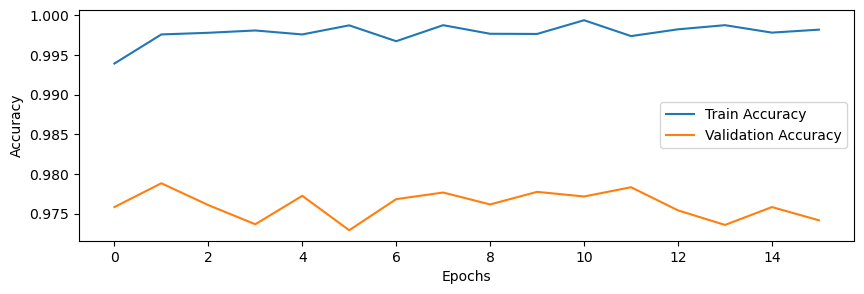

In [20]:
# Plot accuracy over epochs
plt.figure(figsize=(10,3))
plt.plot(historyP.history['accuracy'], label='Train Accuracy')
plt.plot(historyP.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Métricas

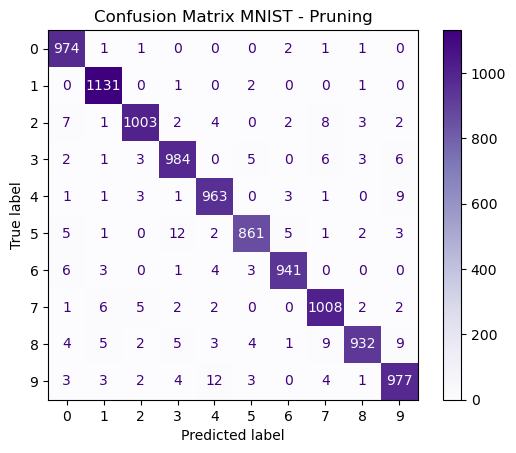

In [21]:
y_pred_probs = modelP.predict(x_test_norm)
y_pred = np.argmax(y_pred_probs, axis=1)

# Since y_test is one-hot encoded, you need to convert it back to class indices
y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels to class indices

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Purples")
plt.title('Confusion Matrix MNIST - Pruning')
plt.show()


#### Guardar el modelo entrenado en disco

In [23]:
modelP = strip_pruning(modelP)
modelP.save('models/mnistModel_FC_P.h5')


####  📝 Ejercicio: 

- Modificar el valor de final_sparsity (0.1, 0.3, 0.5, 0.7, 0.9) y reportar las métricas para cada modelo. Qué conclusión se puede obtener al respecto? 


--- 

### 💡 Quantization (Cuantización)

La cuantización es una técnica que reduce la precisión numérica de los parámetros de una red neuronal, transformando los valores de punto flotante (por ejemplo, 32 bits) a representaciones de menor precisión, como 16 bits o incluso 8 bits. El objetivo principal es reducir el tamaño del modelo y acelerar las inferencias, especialmente en dispositivos con recursos limitados, como teléfonos móviles o microcontroladores.

En este laboratorio vamos a usar **quantization aware-training (QAT)** y **quantization-aware pruning (QAP)** . 

- QAT es una técnica de entrenamiento en la que el modelo aprende a adaptarse a la cuantización antes de ser implementado en hardware. En lugar de entrenar el modelo en precisión completa (punto flotante de 32 bits) y luego cuantizarlo, se introduce la cuantización durante el entrenamiento.

- QAP combina pruning (eliminación de conexiones innecesarias en la red neuronal) con quantization-aware training. El objetivo es reducir el tamaño del modelo antes de cuantizarlo, para obtener una red más eficiente sin sacrificar precisión.

#### 💡 Quantization-aware training

El modelo se re-define haciendo uso de **QKeras**, una extensión de Keras diseñada para crear y entrenar modelos de redes neuronales con cuantización. Su principal objetivo es optimizar modelos para hardware con recursos limitados, como FPGAs, microcontroladores y aceleradores embebidos.

- Permite definir pesos y activaciones con diferentes niveles de precisión (por ejemplo, 8 bits, 4 bits, ternario (-1, 0, 1), etc.).

- Al reducir la precisión numérica, disminuye el uso de memoria y el costo computacional.

- Facilita la conversión de modelos cuantizados en implementaciones eficientes para FPGAs, garantizando la compatibilidad con hls4ml.

- Compatible con capas estándar de Keras, pero con soporte adicional para configuraciones de precisión baja.

Una vez redefinido el modelo a entrenear mediante QKeras, se procede al entrenamiento del mismo. 

**QKeras:** Coelho, C. N., Kuusela, A., Zhuang, H., Aarrestad, T., Loncar, V., Ngadiuba, J., ... & Summers, S. (2020). _Ultra low-latency, low-area inference accelerators using heterogeneous deep quantization with QKeras and hls4ml_. arXiv preprint arXiv:2006.10159, 108.

In [22]:
## Estrategia de cuantización

## Definición del número de bits para kernel, bias, y activación.
# 8-bits

kernelQ = "quantized_bits(8,4,alpha=1)"
biasQ = "quantized_bits(8, 4,alpha=1)"
activationQ = 'quantized_bits(8, 4)'

modelQAT = Sequential(
            [   
                Flatten(input_shape=(28, 28)),
                QDense(100, name='fc1',
                        kernel_quantizer= kernelQ, bias_quantizer= biasQ,
                        kernel_initializer='lecun_uniform'),
                QActivation(activation= activationQ ,  name='relu1'),

                Dropout(0.1),

                QDense(50, name='fc2',
                        kernel_quantizer=kernelQ, bias_quantizer=biasQ,
                        kernel_initializer='lecun_uniform'),
                QActivation(activation=activationQ, name='relu2'), 
                Dropout(0.1),
                

                QDense(20, name='fc3',
                        kernel_quantizer=kernelQ, bias_quantizer=biasQ,
                        kernel_initializer='lecun_uniform'),
                QActivation(activation=activationQ, name='relu3'), 
                
                Dropout(0.1),
                
                QDense(10, name='output',
                        kernel_quantizer= kernelQ, bias_quantizer= biasQ,
                        kernel_initializer='lecun_uniform'),
                Activation(activation='softmax', name='softmax')
               
            ],

            name="quantizedModel",
        )

In [24]:
modelQAT.summary()

Model: "quantizedModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
fc1 (QDense)                 (None, 100)               78500     
_________________________________________________________________
relu1 (QActivation)          (None, 100)               0         
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
fc2 (QDense)                 (None, 50)                5050      
_________________________________________________________________
relu2 (QActivation)          (None, 50)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)             

In [25]:
# Entrenamiento

epochs = 16
lr = 0.001
loss = 'categorical_crossentropy'
op = Adam(lr)
metrics = ['accuracy']
batch = 64
val_split = 0.2


modelQAT.compile(optimizer=op, loss=loss, metrics=metrics)
                
historyQAT = modelQAT.fit(x_train_norm, y_train,
                validation_split = val_split,
                epochs=epochs,
                batch_size = batch,
                verbose=1
                )

Epoch 1/16
750/750 [==============================] - 2s 2ms/step - loss: 2.6137 - accuracy: 0.5808 - val_loss: 0.5225 - val_accuracy: 0.8468
Epoch 2/16
750/750 [==============================] - 1s 1ms/step - loss: 0.7024 - accuracy: 0.7958 - val_loss: 0.4293 - val_accuracy: 0.8773
Epoch 3/16
750/750 [==============================] - 1s 1ms/step - loss: 0.5979 - accuracy: 0.8230 - val_loss: 0.3971 - val_accuracy: 0.8813
Epoch 4/16
750/750 [==============================] - 1s 1ms/step - loss: 0.5695 - accuracy: 0.8307 - val_loss: 0.3988 - val_accuracy: 0.8852
Epoch 5/16
750/750 [==============================] - 1s 1ms/step - loss: 0.5233 - accuracy: 0.8457 - val_loss: 0.4153 - val_accuracy: 0.8816
Epoch 6/16
750/750 [==============================] - 1s 1ms/step - loss: 0.5345 - accuracy: 0.8432 - val_loss: 0.4462 - val_accuracy: 0.8707
Epoch 7/16
750/750 [==============================] - 1s 1ms/step - loss: 0.5268 - accuracy: 0.8441 - val_loss: 0.4310 - val_accuracy: 0.8737
Epoch 

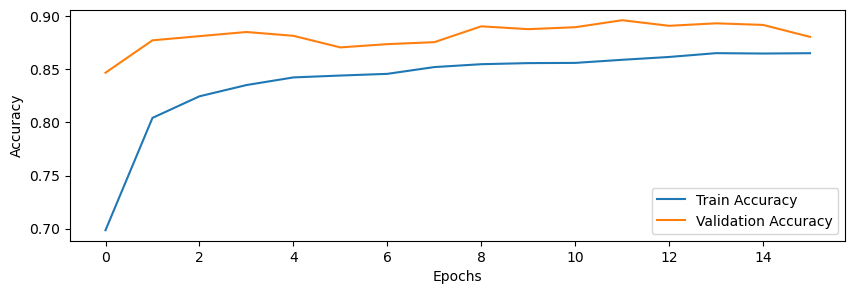

In [27]:
# Plot accuracy over epochs
plt.figure(figsize=(10,3))
plt.plot(historyQAT.history['accuracy'], label='Train Accuracy')
plt.plot(historyQAT.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Métricas

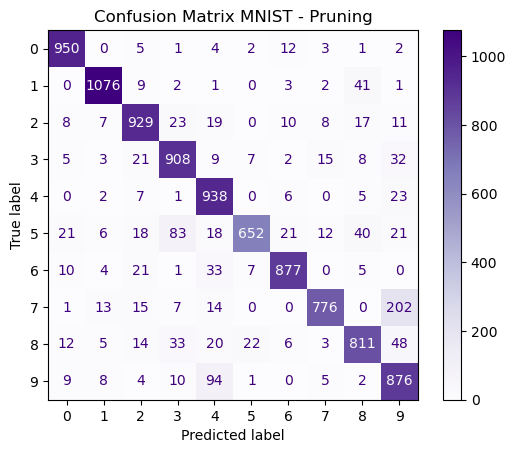

In [28]:
y_pred_probs = modelQAT.predict(x_test_norm)
y_pred = np.argmax(y_pred_probs, axis=1)

# Since y_test is one-hot encoded, you need to convert it back to class indices
y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels to class indices

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Purples")
plt.title('Confusion Matrix MNIST - Pruning')
plt.show()


#### 💡 Quantization-aware pruning

Quantization-aware pruning (QAP) combina pruning con quantization-aware training. El objetivo es reducir el tamaño del modelo luego de cuantizarlo, para obtener una red más eficiente sin sacrificar precisión.

In [29]:
# Estrategia para pruning

final_sparsity = 0.3

pruning_params = {
                'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
                initial_sparsity=0, final_sparsity=final_sparsity, begin_step=0, end_step=3000
                )
            }


In [31]:
## Estrategia de cuantización

## Definición del número de bits para kernel, bias, y activación.
# 8-bits

kernelQ = "quantized_bits(8,4,alpha=1)"
biasQ = "quantized_bits(8, 4,alpha=1)"
activationQ = 'quantized_bits(8, 4)'

modelQ_QAP = Sequential(
            [   
                Flatten(input_shape=(28, 28)),
                QDense(100, name='fc1',
                        kernel_quantizer= kernelQ, bias_quantizer= biasQ,
                        kernel_initializer='lecun_uniform'),
                QActivation(activation= activationQ ,  name='relu1'),

                Dropout(0.1),

                QDense(50, name='fc2',
                        kernel_quantizer=kernelQ, bias_quantizer=biasQ,
                        kernel_initializer='lecun_uniform'),
                QActivation(activation=activationQ, name='relu2'), 
                Dropout(0.1),
                

                QDense(20, name='fc3',
                        kernel_quantizer=kernelQ, bias_quantizer=biasQ,
                        kernel_initializer='lecun_uniform'),
                QActivation(activation=activationQ, name='relu3'), 
                
                Dropout(0.1),
                
                QDense(10, name='output',
                        kernel_quantizer= kernelQ, bias_quantizer= biasQ,
                        kernel_initializer='lecun_uniform'),
                Activation(activation='softmax', name='softmax')
               
            ],

            name="quantizedModel",
        )

In [ ]:
# Entrenamiento


epochs = 16
lr = 0.001
loss = 'categorical_crossentropy'
op = Adam(lr)
metrics = ['accuracy']
batch = 64
val_split = 0.2


modelQAP = tfmot.sparsity.keras.prune_low_magnitude(modelQ_QAP, **pruning_params)

modelQAP.compile(optimizer=op, loss=loss, metrics=metrics)
                
history_QAP = modelQAP.fit(x_train_norm, y_train,
                validation_split = val_split,
                epochs=epochs,
                batch_size = batch,
                callbacks = [tfmot.sparsity.keras.UpdatePruningStep()],
                verbose=1
                )

/tools/anaconda3/envs/neuralEnv/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Epoch 1/16
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (

#### Métricas

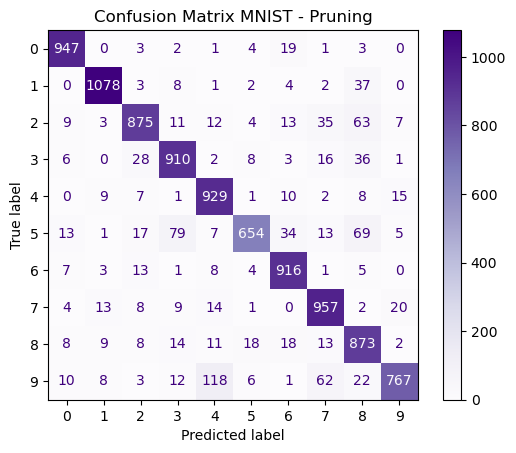

In [33]:
y_pred_probs = modelQAP.predict(x_test_norm)
y_pred = np.argmax(y_pred_probs, axis=1)

# Since y_test is one-hot encoded, you need to convert it back to class indices
y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels to class indices

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Purples")
plt.title('Confusion Matrix MNIST - Pruning')
plt.show()



#### 📝 Ejercicio: 

- Modificar el numero de bits (4, 8, 16, 32) y reportar las metricas de cada modelo, considerando QAT y QAP. Que conclusion puede obtener? 

- Modificar la arquitectura MLP (aumentando o disminuyendo capas) y reemplazando la capa _Flatten_ por _Dense_ . 

--- 

### Knowledge distillation


Esta técnica se dedica a transferir conocimiento de una red grande (_teacher_) a una red objetivo más pequeña y más rápida (_distilled_ o _estudiante_) que puede reproducir el comportamiento de la arquitectura maestra y al mismo tiempo ser computacionalmente menos costosa.

![alt text](../img/lab02/distillation.png)

Para mas información sobre **Knowledge Distillation**: Hinton, G. (2015). _Distilling the Knowledge in a Neural Network_. arXiv preprint arXiv:1503.02531.



In [34]:
# Cargar dataset MNIST
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0            # Normalización

x_train = x_train.reshape(-1, 28 * 28)                       # Aplanar imágenes
x_test = x_test.reshape(-1, 28 * 28)

y_train = to_categorical(y_train, num_classes=10, dtype=int)
y_test = to_categorical(y_test, num_classes=10, dtype=int)

In [35]:
# Definir el modelo Teacher (MLP grande) 

def build_teacher():
    model = keras.Sequential([
        Dense(512, activation="relu", input_shape=(28 * 28,)),
        Dense(256, activation="relu"),
        Dense(10,  activation="softmax")  
    ])
    return model

# Compilar y entrenar el modelo Teacher
teacher = build_teacher()
teacher.summary()

teacher.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
history = teacher.fit(x_train, y_train, epochs=16, batch_size=128, validation_data=(x_test, y_test))



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2570      
Total params: 535,818
Trainable params: 535,818
Non-trainable params: 0
_________________________________________________________________
Epoch 1/16
469/469 [==============================] - 1s 2ms/step - loss: 0.4110 - accuracy: 0.8843 - val_loss: 0.0932 - val_accuracy: 0.9725
Epoch 2/16
469/469 [==============================] - 1s 1ms/step - loss: 0.0832 - accuracy: 0.9741 - val_loss: 0.0782 - val_accuracy: 0.9763
Epoch 3/16
469/469 [==============================] - 1s 1ms/step - loss: 0.0469 - accuracy: 0.9

In [36]:
# Definir el modelo Student (MLP más pequeño)

def build_student():
    model = keras.Sequential([
        Dense(5, activation="relu", input_shape=(28 * 28,)),  
        Dense(7, activation="relu"),
        Dense(10, activation="softmax")  # Softmax en la salida
    ])
    return model

student = build_student()

In [37]:
train_labels = np.argmax(y_train, axis=1)

distilledMLP = Distiller(student=student, teacher=teacher)

In [38]:
distilledMLP.student.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 5)                 3925      
_________________________________________________________________
dense_4 (Dense)              (None, 7)                 42        
_________________________________________________________________
dense_5 (Dense)              (None, 10)                80        
Total params: 4,047
Trainable params: 4,047
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Proceso de destilación del conocimiento

adam = Adam(0.0001)
distilledMLP.compile(
        optimizer=adam,
        metrics=[keras.metrics.SparseCategoricalAccuracy()],
        student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        distillation_loss_fn=keras.losses.KLDivergence(),
        alpha=0.1, 
        temperature=10,
    )

history_distilledMLP = distilledMLP.fit(x_train, train_labels, validation_split=0.2, batch_size = 64, epochs= 32)

Epoch 1/32
750/750 [==============================] - 1s 1ms/step - sparse_categorical_accuracy: 0.1645 - student_loss: 2.0854 - distillation_loss: 4.4567e-04 - val_sparse_categorical_accuracy: 0.2820 - val_student_loss: 1.9770
Epoch 2/32
750/750 [==============================] - 1s 985us/step - sparse_categorical_accuracy: 0.3623 - student_loss: 1.6846 - distillation_loss: 3.8594e-04 - val_sparse_categorical_accuracy: 0.5880 - val_student_loss: 1.4654
Epoch 3/32
750/750 [==============================] - 1s 996us/step - sparse_categorical_accuracy: 0.5968 - student_loss: 1.3214 - distillation_loss: 3.1412e-04 - val_sparse_categorical_accuracy: 0.6679 - val_student_loss: 1.0462
Epoch 4/32
750/750 [==============================] - 1s 970us/step - sparse_categorical_accuracy: 0.6698 - student_loss: 1.0506 - distillation_loss: 2.5166e-04 - val_sparse_categorical_accuracy: 0.7060 - val_student_loss: 0.8308
Epoch 5/32
750/750 [==============================] - 1s 985us/step - sparse_categ

In [ ]:
# Plot accuracy over epochs
plt.figure(figsize=(15,3))
plt.plot(history_distilledMLP.history['sparse_categorical_accuracy'], label='Train Accuracy')
plt.plot(history_distilledMLP.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over epochs')
plt.show()

In [ ]:
# Plot loss over epochs
plt.figure(figsize=(15,3))
plt.plot(history_distilledMLP.history['student_loss'], label='Train Loss')
plt.plot(history_distilledMLP.history['val_student_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over epochs')
plt.show()


#### Métricas

In [ ]:
y_pred_probs = distilledMLP.student.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Since y_test is one-hot encoded, you need to convert it back to class indices
y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels to class indices

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Purples')
plt.show()


#### Guardar el modelo entrenado en disco

In [ ]:
distilledMLP.student.save("models/mnistKD.h5")

--------

#### 📝 Ejercicios

- Variar la arquitectura del estudiante y analizar el rendimiento del modelo entrenado mediante las métricas correspondientes. Considerar los siguientes escenarios:
    
    - Disminuir el numero de capas.

    - Variar la cantidad de neuronas en cada capa. 

    - Incrementar la cantidad de capas y disminuir la cantidad de neuronas en cada una de las capas. 

- Repetir los procesos de compresión para MNIST fashion y CIFAR-10 datasets. 

- ¿Qué conclusiones puede obtener? 

- 🎯 Para continuar con el próximo laboratorio: 

    -  **Para MNIST dataset, definir un clasificador binario: que discrimine solamente entre 6 y 9, o entre 7 y 5. Aplicar Quantization-Aware Pruning como método de entrenamiento y compresión.** 

    - **Para el mismo escenario, emplee QAT combinado con Knowledge Distillation**.
